In [ ]:
!pip install keras-tuner --upgrade

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
import keras_tuner as kt
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import itertools
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier 

In [ ]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total  --format=csv

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



#Analise Exploratória de dados

In [ ]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut_Reduzido_Final.csv',sep = ';', header=0).iloc[:,1:]

V1 = np.array(dados_crus.pop('Semenov'))
V2 = np.array(dados_crus.pop('T_Limite'))

Labels = []
for i in range(len(V1)):
  if V1[i] > 0 or V2[i]> 0:
    Labels.append(1)
  else:
    Labels.append(0)

Labels = np.array(Labels)

dados_crus

Tempo      Conc    T_Reator  ...       Ffj           Qm           Qr
0         0.000000  2.000000  311.150000  ...  1.524363    18.037788   135.694981
1         0.606061  1.978296  310.158835  ...  1.524363    16.253297   129.292939
2         1.212121  1.957900  309.208465  ...  1.524363    14.701465   123.177082
3         1.818182  1.938686  308.298080  ...  1.524363    13.347991   117.338962
4         2.424242  1.920547  307.426707  ...  1.524363    12.164007   111.769557
...            ...       ...         ...  ...       ...          ...          ...
4665595  57.575758  0.000003  819.283815  ...  6.360796  1968.714364  2073.853047
4665596  58.181818  0.000003  819.309267  ...  6.360796  1968.714364  2073.760912
4665597  58.787879  0.000003  819.333491  ...  6.360796  1968.714364  2073.673176
4665598  59.393939  0.000003  819.356547  ...  6.360796  1968.714364  2073.589632
4665599  60.000000  0.000003  819.378490  ...  6.360796  1968.714364  2073.510081

[4665600 rows x 21 columns]

In [ ]:
dados_crus.describe()

Tempo          Conc  ...            Qm            Qr
count  4.665600e+06  4.665600e+06  ...  4.665600e+06  4.665600e+06
mean   3.000000e+01  1.850084e+00  ...  3.087708e+02  3.047672e+02
std    1.749459e+01  1.700616e+00  ...  4.920795e+03  4.697933e+02
min    0.000000e+00  1.266563e-06  ...  1.214624e+00 -6.671002e+01
25%    1.500000e+01  1.129813e-02  ...  1.212015e+01  1.387602e+01
50%    3.000000e+01  1.829814e+00  ...  4.489911e+01  4.397579e+01
75%    4.500000e+01  2.788471e+00  ...  3.989778e+02  4.893158e+02
max    6.000000e+01  6.240595e+00  ...  9.687765e+06  2.369480e+03

[8 rows x 21 columns]

In [ ]:
print('{:.2%} of data consist of runaway instances'.format(Labels.sum() / len(dados_crus)))

23.82% of data consist of runaway instances


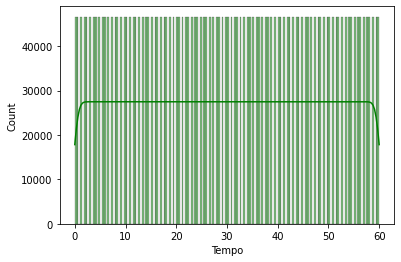

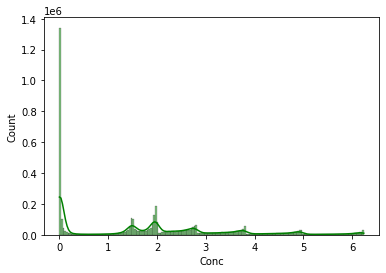

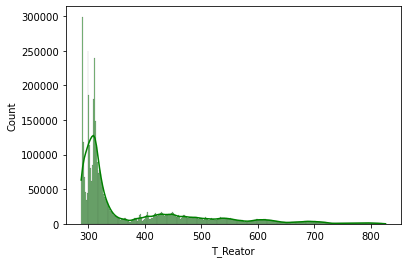

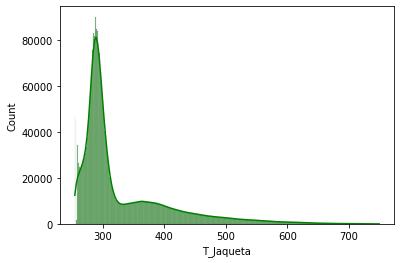

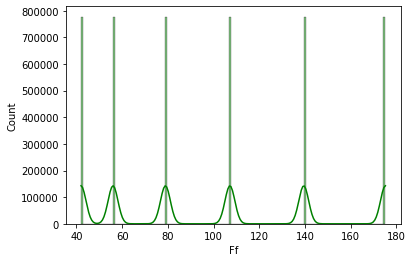

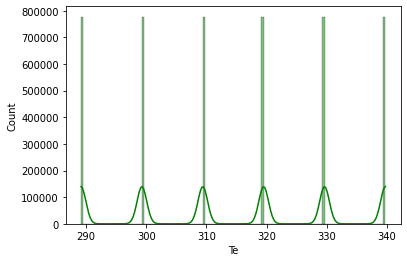

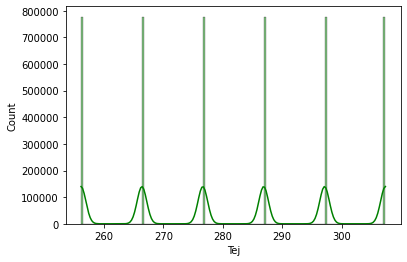

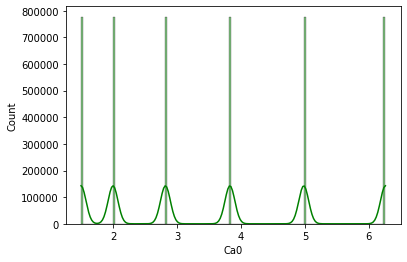

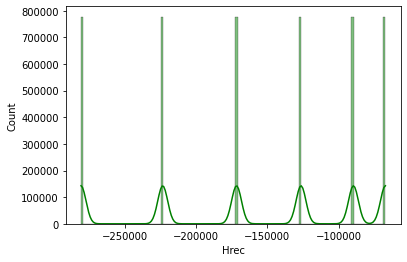

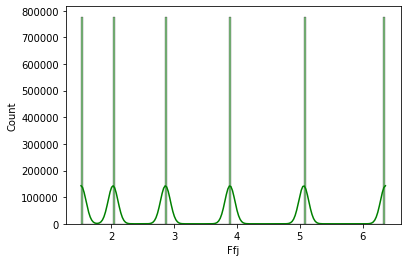

In [ ]:
sns.color_palette("pastel")
for i in ['Tempo','Conc','T_Reator','T_Jaqueta','Ff','Te','Tej','Ca0','Hrec','Ffj']:
  sns.histplot(dados_crus[i],kde=True, color='green')
  plt.show()

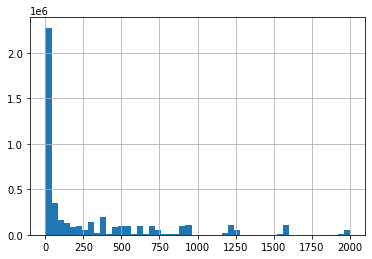

In [ ]:
dados_crus.query('Qm < 2e3')["Qm"].hist(bins=50) # There are some tremendous big occurrences of heat made in the reactor

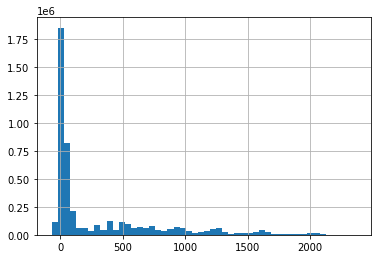

In [ ]:
dados_crus["Qr"].hist(bins=50) # Heat removed by the jacket

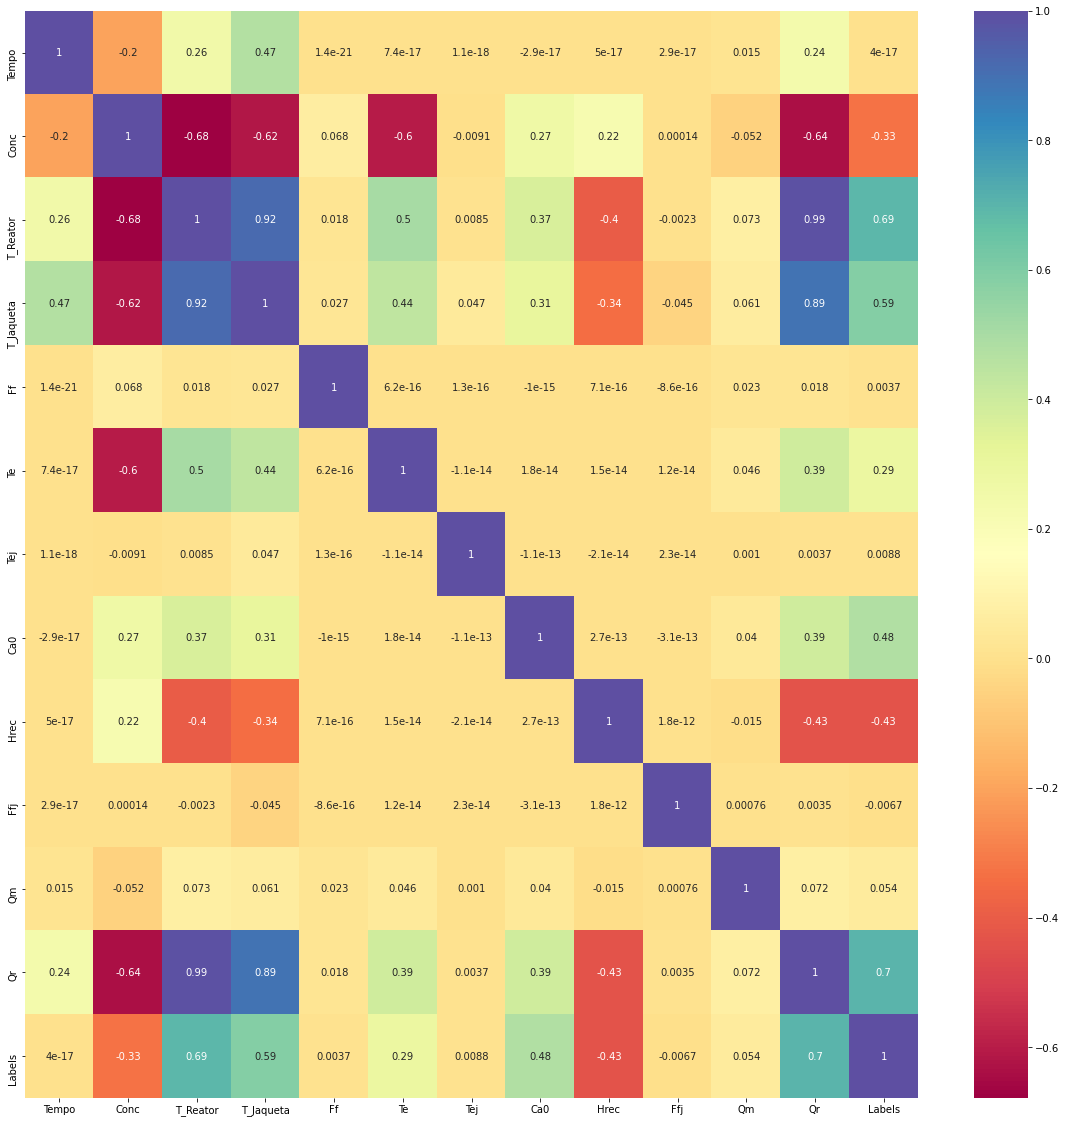

In [ ]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut_Reduzido_Final.csv',sep = ';', header=0).iloc[:, [1,2,3,4,5,7,8,10,12,19,20,21]]
dados_crus['Labels'] = Labels

plt.figure(figsize=(20,20))
sns.heatmap(dados_crus.corr(),annot=True,cmap='Spectral')

In [ ]:
sns.pairplot(dados_crus)

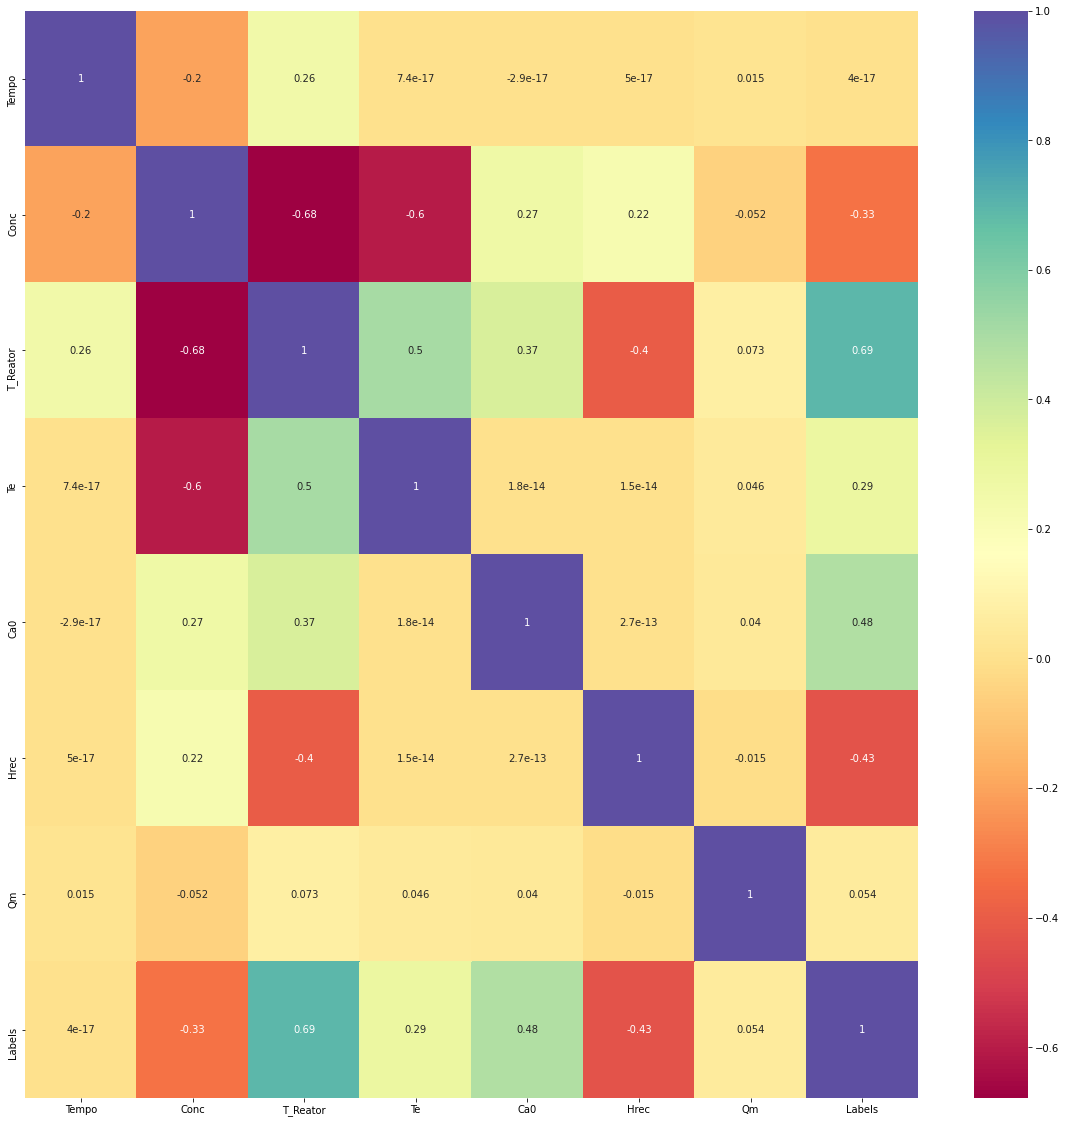

In [ ]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut_Reduzido_Final.csv',sep = ';', header=0).iloc[:, [1,2,3,7,10,12,20]]
dados_crus['Labels'] = Labels

plt.figure(figsize=(20,20))
sns.heatmap(dados_crus.corr(),annot=True,cmap='Spectral')

**Há uma diferença imensa no desempenho dos métodos de árvore dropando as colunas muito correlacionadas. PARA PCA FILTRAR AJUDOU A CONVERGIR, JÁ NOS DADOS NORMAIS ATRAPALHOU COMPLETAMENTE A CLASSIFICAÇÃO**

# Normal Dataset (Filtrado e Normalizado)

In [3]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut_Reduzido_Final.csv',sep = ';', header=0)
#dados_crus = dados_crus.iloc[:, [1,2,3,4,5,7,8,10,12,19,20,21,-1,-2]]
dados_crus = dados_crus.iloc[:, [1,2,3,7,10,12,20,-1,-2]]
V1 = np.array(dados_crus.pop('Semenov'))
V2 = np.array(dados_crus.pop('T_Limite'))

Labels = []
for i in range(len(V1)):
  if V1[i] > 0 or V2[i]> 0:
    Labels.append(1)
  else:
    Labels.append(0)

Labels = np.array(Labels)
dados_crus['Labels'] = Labels

In [4]:
scaler = StandardScaler()

df_runaway = dados_crus.query('Labels > 0')

test_dataset_runaway = df_runaway.sample(n=round(dados_crus.shape[0]*0.01*0.5), random_state=1) #metade do teste feito de operações que geraram runaway

NormalOp = dados_crus.drop(df_runaway.index) #ou .query / Operações normais

test_dataset_NormalOp = NormalOp.sample(n=round(dados_crus.shape[0]*0.01*0.5), random_state=1) # outra metade com instâncias normais de operação

Test_dataset = pd.concat([test_dataset_runaway,test_dataset_NormalOp])    # Dataset de Teste

Train_dataset = dados_crus.drop(Test_dataset.index)   


Test_dataset_Labels = Test_dataset.pop('Labels')


Train_dataset_Labels = Train_dataset.pop('Labels') # Dataset de Treino

Train_dataset

Train_dataset = scaler.fit_transform(Train_dataset)
Test_dataset = scaler.fit_transform(Test_dataset)

In [ ]:
dados_crus

Tempo      Conc    T_Reator  ...      Hrec           Qm  Labels
0         0.000000  2.000000  311.150000  ...  -67275.0    18.037788       0
1         0.606061  1.978296  310.158835  ...  -67275.0    16.253297       0
2         1.212121  1.957900  309.208465  ...  -67275.0    14.701465       0
3         1.818182  1.938686  308.298080  ...  -67275.0    13.347991       0
4         2.424242  1.920547  307.426707  ...  -67275.0    12.164007       0
...            ...       ...         ...  ...       ...          ...     ...
4665595  57.575758  0.000003  819.283815  ... -280722.2  1968.714364       1
4665596  58.181818  0.000003  819.309267  ... -280722.2  1968.714364       1
4665597  58.787879  0.000003  819.333491  ... -280722.2  1968.714364       1
4665598  59.393939  0.000003  819.356547  ... -280722.2  1968.714364       1
4665599  60.000000  0.000003  819.378490  ... -280722.2  1968.714364       1

[4665600 rows x 8 columns]

# Dataset_PCA

In [5]:
dados_crus = pd.read_csv('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste_GPU/OutPut_Reduzido_Final.csv',sep = ';', header=0)
dados_crus = dados_crus.iloc[:, [1,2,3,7,10,12,20,-1,-2]]

dados_crus.pop('Semenov')
dados_crus.pop('T_Limite')


X_reduced = pd.DataFrame(dados_crus)
pca = PCA(n_components=5)
X_reduced = pd.DataFrame(pca.fit_transform(X_reduced))

X_reduced['Labels'] = Labels
dados_crus['Labels'] = Labels

df_runaway_PCA = X_reduced.query('Labels > 0')


test_dataset_runaway_PCA = df_runaway_PCA.sample(n=round(X_reduced.shape[0]*0.01*0.5), random_state=1) #metade do teste feito de operações que geraram runaway

NormalOp_PCA = X_reduced.drop(df_runaway_PCA.index) #ou .query

test_dataset_NormalOp_PCA = NormalOp_PCA.sample(n=round(X_reduced.shape[0]*0.01*0.5), random_state=1) #outra metade com instâncias comuns de operação

Test_dataset_PCA = pd.concat([test_dataset_runaway_PCA,test_dataset_NormalOp_PCA])

Train_dataset_PCA = X_reduced.drop(Test_dataset_PCA.index)

Test_dataset_PCA_Labels = Test_dataset_PCA.pop('Labels')

Train_dataset_PCA_Labels = Train_dataset_PCA.pop('Labels')


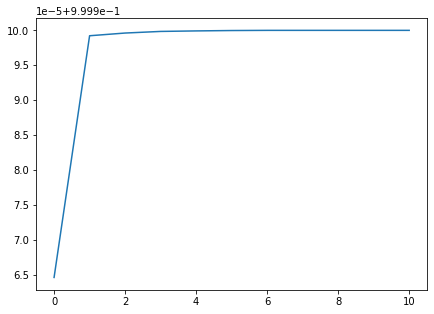

In [58]:
plt.figure(figsize=(7,5))
pca_dummy = PCA(n_components=None)
X_dummy = dados_crus.iloc[:,:-1]
X_dummy = pca_dummy.fit_transform(X_dummy)
plt.plot(np.cumsum(pca_dummy.explained_variance_ratio_)[1:])

In [8]:
np.cumsum(pca_dummy.explained_variance_ratio_)

array([0.99563482, 0.99996463, 0.99999923, 0.99999962, 0.99999985,
       0.99999992, 0.99999997, 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [ ]:
X_reduced

0            1            2          3          4  Labels
0        -92605.293770  -196.279854   -70.891667  60.274383 -68.597596       0
1        -92605.312950  -198.104723   -64.792079  60.147938 -65.710937       0
2        -92605.331125  -199.695153   -58.960752  60.027833 -62.964112       0
3        -92605.348354  -201.085494   -53.390361  59.913788 -60.350892       0
4        -92605.364688  -202.304668   -48.072923  59.805529 -57.865184       0
...                ...          ...          ...        ...        ...     ...
4665595  120848.649578  1547.189661 -1498.698425 -74.175054  48.699878       1
4665596  120848.649431  1547.189370 -1498.658679 -74.188374  49.130533       1
4665597  120848.649291  1547.189095 -1498.621131 -74.201186  49.549102       1
4665598  120848.649158  1547.188835 -1498.585679 -74.213514  49.956164       1
4665599  120848.649031  1547.188588 -1498.552225 -74.225381  50.352272       1

[4665600 rows x 6 columns]

# Reducing Datasets

Vou usar nosso dataset de treino para criar datasets de treino e validação reduzidos


In [6]:
Train_dataset_PCA_Reduced , Test_dataset_PCA_reduced , Train_dataset_PCA_Labels_Reduced, Test_dataset_PCA_Labels_reduced = train_test_split(
    Test_dataset_PCA, Test_dataset_PCA_Labels,
    random_state=0,test_size=0.1)


Train_dataset_Reduced , Test_dataset_reduced , Train_dataset_Labels_Reduced, Test_dataset_Labels_reduced = train_test_split(
    Test_dataset, Test_dataset_Labels,
    random_state=0,test_size=0.1)

In [ ]:
print(Train_dataset_PCA_Reduced.shape[0]/ X_reduced.shape[0]*100,'% of dataset used to train')

0.8999914266117969 % of dataset used to train


# Cont

In [6]:
Labels.sum()/ dados_crus.shape[0]  # 23.8% do dataset é de classe runaway

0.23823302469135801

In [7]:
test_dataset_runaway.shape

(23328, 8)

In [8]:
test_dataset_NormalOp.shape

(23328, 8)

In [9]:
Test_dataset.shape

(46656, 7)

In [10]:
Test_dataset_PCA.shape

(46656, 5)

In [11]:
dados_crus.shape

(4665600, 8)

In [12]:
Test_dataset.shape[0]+Train_dataset.shape[0]

4665600

In [13]:
len(Labels)

4665600

 **Antes de prosseguir com outra classificação, reinicie o kernel** 

# TensorFlow / Keras

## Normal Dataset Train (Tratado)

In [22]:
model=keras.Sequential()

model.add(keras.layers.Dense(64,input_shape=[7],  #Preferi deixar o input_shape no manual para evitar confusão
                             bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(32,activation = 'LeakyReLU'))

model.add(keras.layers.Dense(16,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(16,activation = 'LeakyReLU'))

model.add(keras.layers.Dense(16,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(8,activation = 'LeakyReLU'))



model.add(keras.layers.Dense(1, activation='sigmoid'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                512       
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)                64        
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 16)               

In [24]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-6),loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.FalseNegatives()])

In [25]:
Train_dataset.shape

(4618944, 7)

In [26]:
history = model.fit(x=Train_dataset,
                    y=Train_dataset_Labels,validation_data = (Test_dataset,Test_dataset_Labels)
                    ,validation_steps = len(Test_dataset)/256 ,epochs = 12 ,batch_size=256,verbose=1
                    )

Epoch 1/12
18043/18043 [==============================] - 58s 3ms/step - loss: 0.4102 - accuracy: 0.8516 - auc_1: 0.8669 - false_negatives_1: 471259.0000 - val_loss: 0.4445 - val_accuracy: 0.7943 - val_auc_1: 0.9421 - val_false_negatives_1: 9592.0000
Epoch 2/12
18043/18043 [==============================] - 56s 3ms/step - loss: 0.1925 - accuracy: 0.9544 - auc_1: 0.9858 - false_negatives_1: 120924.0000 - val_loss: 0.4299 - val_accuracy: 0.7983 - val_auc_1: 0.9717 - val_false_negatives_1: 9408.0000
Epoch 3/12
18043/18043 [==============================] - 57s 3ms/step - loss: 0.1282 - accuracy: 0.9639 - auc_1: 0.9928 - false_negatives_1: 98855.0000 - val_loss: 0.4623 - val_accuracy: 0.8028 - val_auc_1: 0.9838 - val_false_negatives_1: 9201.0000
Epoch 4/12
18043/18043 [==============================] - 56s 3ms/step - loss: 0.0998 - accuracy: 0.9686 - auc_1: 0.9949 - false_negatives_1: 85505.0000 - val_loss: 0.5070 - val_accuracy: 0.8050 - val_auc_1: 0.9872 - val_false_negatives_1: 9096.000

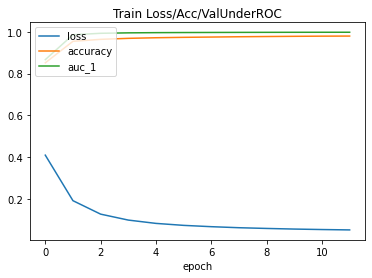

In [27]:
for i in ['loss', 'accuracy','auc_1']:
  plt.plot(history.history[i])
plt.title('Train Loss/Acc/ValUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc_1'], loc='upper left')
plt.show()

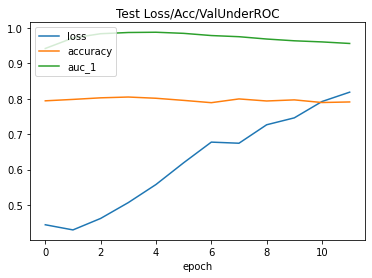

In [29]:
for i in ['val_loss', 'val_accuracy','val_auc_1']:
  plt.plot(history.history[i])
plt.title('Test Loss/Acc/ValUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc_1'], loc='upper left')
plt.show()

## Normal Dataset Train (Dataset não filtrado)

In [4]:
model=keras.Sequential()

model.add(keras.layers.Dense(64,input_shape=[12],  #Preferi deixar o input_shape no manual para evitar confusão
                             bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(32,activation = 'LeakyReLU'))

model.add(keras.layers.Dense(16,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(16,activation = 'LeakyReLU'))

model.add(keras.layers.Dense(16,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(8,activation = 'LeakyReLU'))



model.add(keras.layers.Dense(1, activation='sigmoid'))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2

In [6]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-6),loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.FalseNegatives()])

In [7]:
Train_dataset.shape

(4618944, 12)

In [8]:
history = model.fit(x=Train_dataset,
                    y=Train_dataset_Labels,validation_data = (Test_dataset,Test_dataset_Labels)
                    ,validation_steps = len(Test_dataset)/256 ,epochs = 12 ,batch_size=256,verbose=1
                    )

Epoch 1/12
18043/18043 [==============================] - 57s 3ms/step - loss: 0.4634 - accuracy: 0.8222 - auc: 0.8656 - false_negatives: 365821.0000 - val_loss: 0.3719 - val_accuracy: 0.8311 - val_auc: 0.9625 - val_false_negatives: 7582.0000
Epoch 2/12
18043/18043 [==============================] - 55s 3ms/step - loss: 0.2357 - accuracy: 0.9390 - auc: 0.9783 - false_negatives: 130062.0000 - val_loss: 0.3366 - val_accuracy: 0.8184 - val_auc: 0.9796 - val_false_negatives: 8429.0000
Epoch 3/12
18043/18043 [==============================] - 55s 3ms/step - loss: 0.1590 - accuracy: 0.9581 - auc: 0.9892 - false_negatives: 111109.0000 - val_loss: 0.3602 - val_accuracy: 0.8109 - val_auc: 0.9850 - val_false_negatives: 8807.0000
Epoch 4/12
18043/18043 [==============================] - 55s 3ms/step - loss: 0.1197 - accuracy: 0.9648 - auc: 0.9930 - false_negatives: 102613.0000 - val_loss: 0.3879 - val_accuracy: 0.8105 - val_auc: 0.9877 - val_false_negatives: 8831.0000
Epoch 5/12
18043/18043 [====

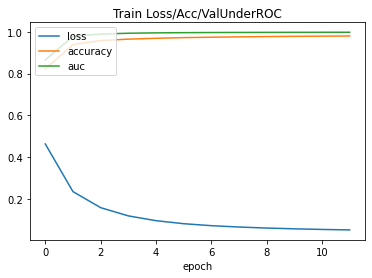

In [10]:
for i in ['loss', 'accuracy','auc']:
  plt.plot(history.history[i])
plt.title('Train Loss/Acc/ValUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc'], loc='upper left')
plt.show()

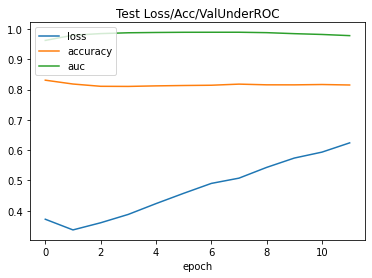

In [11]:
for i in ['val_loss', 'val_accuracy','val_auc']:
  plt.plot(history.history[i])
plt.title('Test Loss/Acc/ValUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc'], loc='upper left')
plt.show()

## PCA Dataset Train (Tratado)

In [8]:
model2=keras.Sequential()

model2.add(keras.layers.Dense(64,input_shape=[5],
                             bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model2.add(keras.layers.BatchNormalization())

model2.add(keras.layers.Dense(32,activation = 'LeakyReLU'))

model2.add(keras.layers.Dense(16,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model2.add(keras.layers.BatchNormalization())

model2.add(keras.layers.Dense(16,activation = 'LeakyReLU'))

model2.add(keras.layers.Dense(32,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model2.add(keras.layers.BatchNormalization())

model2.add(keras.layers.Dense(16,activation = 'LeakyReLU'))



model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [9]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                5

In [11]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.FalseNegatives()])

In [12]:
history2 = model2.fit(x=Train_dataset_PCA,y=Train_dataset_PCA_Labels,validation_data = (Test_dataset_PCA,Test_dataset_PCA_Labels),
                     validation_steps = len(Test_dataset)/256 ,epochs = 20 ,batch_size=256,verbose=1
                     )

Epoch 1/20
18043/18043 [==============================] - 59s 3ms/step - loss: 0.2583 - accuracy: 0.9021 - auc_1: 0.9275 - false_negatives_1: 330366.0000 - val_loss: 0.3916 - val_accuracy: 0.8176 - val_auc_1: 0.9487 - val_false_negatives_1: 8411.0000
Epoch 2/20
18043/18043 [==============================] - 57s 3ms/step - loss: 0.1943 - accuracy: 0.9222 - auc_1: 0.9591 - false_negatives_1: 308482.0000 - val_loss: 0.2492 - val_accuracy: 0.8967 - val_auc_1: 0.9668 - val_false_negatives_1: 3536.0000
Epoch 3/20
18043/18043 [==============================] - 57s 3ms/step - loss: 0.1667 - accuracy: 0.9305 - auc_1: 0.9716 - false_negatives_1: 259752.0000 - val_loss: 0.2218 - val_accuracy: 0.9030 - val_auc_1: 0.9769 - val_false_negatives_1: 3931.0000
Epoch 4/20
18043/18043 [==============================] - 57s 3ms/step - loss: 0.1539 - accuracy: 0.9345 - auc_1: 0.9764 - false_negatives_1: 229824.0000 - val_loss: 0.2263 - val_accuracy: 0.8842 - val_auc_1: 0.9825 - val_false_negatives_1: 5269.0

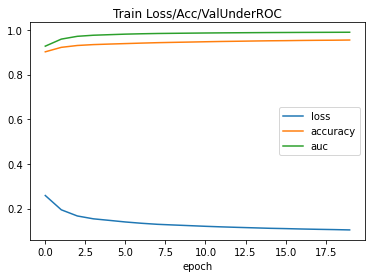

In [13]:
for i in ['loss', 'accuracy','auc_1']:
  plt.plot(history2.history[i])
plt.title('Train Loss/Acc/ValUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc'], loc='best')
plt.show()

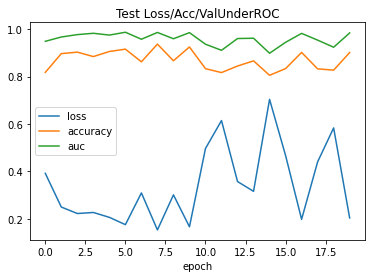

In [17]:
for i in ['val_loss', 'val_accuracy','val_auc_1']:
  plt.plot(history2.history[i])
plt.title('Test Loss/Acc/ValUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc'], loc='best')
plt.show()

##PCA Dataset Train (Dataset não filtrado)

In [10]:
model2=keras.Sequential()

model2.add(keras.layers.Dense(64,input_shape=[8],
                             bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model2.add(keras.layers.BatchNormalization())

model2.add(keras.layers.Dense(32,activation = 'LeakyReLU'))

model2.add(keras.layers.Dense(16,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model2.add(keras.layers.BatchNormalization())

model2.add(keras.layers.Dense(16,activation = 'LeakyReLU'))

model2.add(keras.layers.Dense(32,bias_regularizer=regularizers.l1(1e-3),
                             activation = 'LeakyReLU'))
model2.add(keras.layers.BatchNormalization())

model2.add(keras.layers.Dense(16,activation = 'LeakyReLU'))



model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [11]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                5

In [12]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.FalseNegatives()])

In [13]:
history2 = model2.fit(x=Train_dataset_PCA,y=Train_dataset_PCA_Labels,validation_data = (Test_dataset_PCA,Test_dataset_PCA_Labels),
                     validation_steps = len(Test_dataset)/256 ,epochs = 20 ,batch_size=256,verbose=1
                     )

Epoch 1/20
18043/18043 [==============================] - 61s 3ms/step - loss: 0.2343 - accuracy: 0.9114 - auc: 0.9391 - false_negatives: 295866.0000 - val_loss: 0.2882 - val_accuracy: 0.8689 - val_auc: 0.9494 - val_false_negatives: 3970.0000
Epoch 2/20
18043/18043 [==============================] - 59s 3ms/step - loss: 0.1656 - accuracy: 0.9313 - auc: 0.9714 - false_negatives: 245712.0000 - val_loss: 0.2745 - val_accuracy: 0.8834 - val_auc: 0.9603 - val_false_negatives: 4490.0000
Epoch 3/20
18043/18043 [==============================] - 60s 3ms/step - loss: 0.1521 - accuracy: 0.9351 - auc: 0.9766 - false_negatives: 224905.0000 - val_loss: 0.2376 - val_accuracy: 0.8843 - val_auc: 0.9768 - val_false_negatives: 5000.0000
Epoch 4/20
18043/18043 [==============================] - 60s 3ms/step - loss: 0.1433 - accuracy: 0.9377 - auc: 0.9798 - false_negatives: 211503.0000 - val_loss: 0.5838 - val_accuracy: 0.8067 - val_auc: 0.9094 - val_false_negatives: 4164.0000
Epoch 5/20
18043/18043 [====

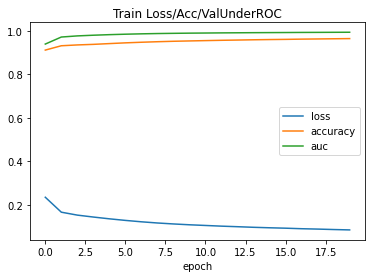

In [14]:
for i in ['loss', 'accuracy','auc']:
  plt.plot(history2.history[i])
plt.title('Train Loss/Acc/ValUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc'], loc='best')
plt.show()

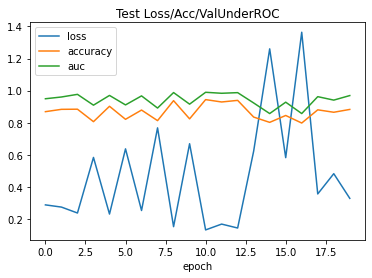

In [15]:
for i in ['val_loss', 'val_accuracy','val_auc']:
  plt.plot(history2.history[i])
plt.title('Test Loss/Acc/ValUnderROC')

plt.xlabel('epoch')
plt.legend(['loss', 'accuracy','auc'], loc='best')
plt.show()

## Keras Tuner

In [17]:
def build_model(hp):
  model = keras.Sequential()

  model.add(keras.layers.Dense(
        hp.Choice('unitsPre1', [64]),
        bias_regularizer=regularizers.l1(1e-6),
        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6),
        activation='LeakyReLU'))
  
  model.add(keras.layers.Dense(
      hp.Choice('unitsPre2', [32, 64]),
      bias_regularizer=regularizers.l1(1e-6),
      kernel_regularizer=regularizers.l2(1e-5),
      activation='LeakyReLU'))
  
  for i in range(hp.Int('num_layers',5,8)):
    if i % 2 == 0:
      model.add(keras.layers.Dense(
        hp.Choice('units' + str(i), [16, 32]),

        bias_regularizer=regularizers.l1(1e-6),
        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6),
        activity_regularizer=regularizers.l2(1e-6),

        activation='LeakyReLU'))
      model.add(keras.layers.BatchNormalization())
    else:
      model.add(keras.layers.Dense(
          hp.Choice('units' + str(i), [16, 32]),
          activation='LeakyReLU'))
      
  
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',[1e-5,1e-6])),loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.FalseNegatives()])
  #model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001
   #                                                   ,initial_accumulator_value=0.1,epsilon=1e-07,name="Adagrad"),loss='binary_crossentropy',metrics=['mae','mse','accuracy'])
  
  return model

In [20]:
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=12,
                     factor=4,
                     directory='/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/',
                     project_name='Reactor_NN_Tuner_Hyperband_Final_PCA(8)',
                     overwrite=False)
tuner.search(Train_dataset_PCA, Train_dataset_PCA_Labels,
             validation_data=(Test_dataset_PCA, Test_dataset_PCA_Labels),
             validation_steps = len(Test_dataset)/400 ,batch_size=400)

Trial 11 Complete [00h 09m 56s]
val_accuracy: 0.8487439751625061

Best val_accuracy So Far: 0.9157236218452454
Total elapsed time: 01h 02m 40s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=8,
                     factor=4,
                     directory='/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/',
                     project_name='Reactor_NN_Tuner_Hyperband_F',
                     overwrite=True)
tuner.search(Train_dataset_PCA, Train_dataset_PCA_Labels,
             validation_data=(Test_dataset_PCA, Test_dataset_PCA_Labels),
             validation_steps = len(Test_dataset)/400 ,batch_size=400)
#tuner.get_best_models()

Trial 11 Complete [00h 12m 25s]
val_accuracy: 0.8535879850387573

Best val_accuracy So Far: 0.885073721408844
Total elapsed time: 01h 15m 28s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_accuracy", direction="max"),
    executions_per_trial=1,
    max_trials=40,
    directory ='/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/',
    project_name='Reactor_NN_Tuner2',
    overwrite = True)

#tuner.search(Train_dataset_PCA, Train_Labels, 
#             epochs=5, validation_data=(Test_dataset_PCA, Test_Labels),
#             validation_steps = len(Test_dataset)/400 ,batch_size=400)


[]

In [22]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Reactor_NN_Tuner_Hyperband_Final_PCA(8)
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
unitsPre1: 64
unitsPre2: 64
num_layers: 6
units0: 16
units1: 16
units2: 16
units3: 16
units4: 16
learning_rate: 1e-05
units5: 16
units6: 32
tuner/epochs: 12
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9157236218452454
Trial summary
Hyperparameters:
unitsPre1: 64
unitsPre2: 32
num_layers: 7
units0: 16
units1: 32
units2: 16
units3: 16
units4: 16
learning_rate: 1e-05
units5: 16
units6: 32
tuner/epochs: 12
tuner/initial_epoch: 3
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 2a4e1d441aaca8210a1bab40b2edfaaf
Score: 0.8862311244010925
Trial summary
Hyperparameters:
unitsPre1: 64
unitsPre2: 32
num_layers: 7
units0: 16
units1: 16
units2: 16
units3: 16
units4: 32
learning_rate: 1e-05
units5: 16
units6: 32
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket:

In [23]:
best_hps=tuner.get_best_hyperparameters(num_trials=20)[0]
model = tuner.hypermodel.build(best_hps)
#model.load_weights(tf.train.latest_checkpoint('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Reactor_NN_Tuner_Hyperband+2/trial_d816f1bbcd21a1c8c83d7ecfbca6dbd1/checkpoints/epoch_0'))
model.build((Train_dataset_PCA.shape[0],8))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (4618944, 32)             192       
_________________________________________________________________
dense_1 (Dense)              (4618944, 64)             2112      
_________________________________________________________________
dense_2 (Dense)              (4618944, 16)             1040      
_________________________________________________________________
batch_normalization (BatchNo (4618944, 16)             64        
_________________________________________________________________
dense_3 (Dense)              (4618944, 32)             544       
_________________________________________________________________
dense_4 (Dense)              (4618944, 16)             528       
_________________________________________________________________
batch_normalization_1 (Batch (4618944, 16)             6

In [24]:
# É melhor treinar novamente ao invés de carregar os pesos do tuner
history = model.fit(x=Train_dataset_PCA,y=Train_dataset_PCA_Labels,validation_data = (Test_dataset_PCA,Test_dataset_PCA_Labels)
                    ,validation_steps = len(Test_dataset)/400 ,epochs = 8 ,batch_size=400,verbose=1
                    )

Epoch 1/8
11548/11548 [==============================] - 47s 4ms/step - loss: 50.1680 - accuracy: 0.8632 - auc: 0.9023 - false_negatives: 303837.0000 - val_loss: 0.4267 - val_accuracy: 0.8424 - val_auc: 0.9330 - val_false_negatives: 6572.0000
Epoch 2/8
11548/11548 [==============================] - 44s 4ms/step - loss: 0.5823 - accuracy: 0.9264 - auc: 0.9648 - false_negatives: 268425.0000 - val_loss: 0.3280 - val_accuracy: 0.8776 - val_auc: 0.9574 - val_false_negatives: 4289.0000
Epoch 3/8
11548/11548 [==============================] - 44s 4ms/step - loss: 0.4142 - accuracy: 0.9306 - auc: 0.9712 - false_negatives: 244561.0000 - val_loss: 0.2892 - val_accuracy: 0.8740 - val_auc: 0.9731 - val_false_negatives: 5471.0000
Epoch 4/8
11548/11548 [==============================] - 44s 4ms/step - loss: 0.2956 - accuracy: 0.9318 - auc: 0.9732 - false_negatives: 237750.0000 - val_loss: 0.2651 - val_accuracy: 0.8872 - val_auc: 0.9676 - val_false_negatives: 3902.0000
Epoch 5/8
11548/11548 [========

In [ ]:
#Daí então você salva os pesos bem treinados:
model.save_weights('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Pesos_Modelo_otimo.h5', overwrite=False)


In [ ]:
#E pode carregá-los:
model.load_weights('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/Pesos_Modelo_otimo.h5')


## Confusion matrix

In [10]:
def plot_confusion_matrix(cm, classes,
                        normalize=True,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[22897   431]
 [ 5625 17703]]


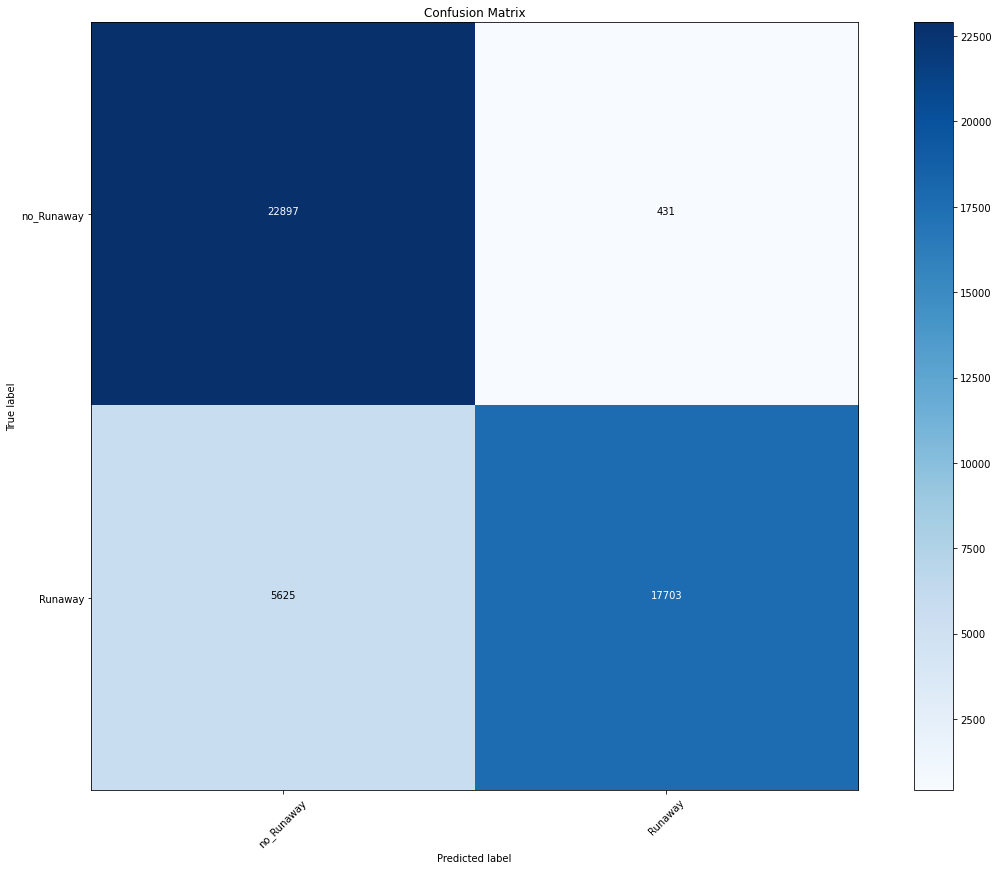

In [28]:
predictions = model.predict(
      x=Test_dataset_PCA
    , batch_size=400
    , verbose=0
)  

rounded_predictions = np.argmax(predictions, axis=-1)

cm = confusion_matrix(y_true=Test_dataset_PCA_Labels, y_pred=predictions.round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


# SVM

##Normal Dataset

##PCA

In [74]:
clf = NuSVC(kernel='sigmoid',verbose=True, probability=True)
clf.fit(Train_dataset_PCA_Reduced,Train_dataset_PCA_Labels_Reduced)

[LibSVM]

NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
      max_iter=-1, nu=0.5, probability=True, random_state=None, shrinking=True,
      tol=0.001, verbose=True)

In [75]:
clf.score(Train_dataset_PCA_Reduced,Train_dataset_PCA_Labels_Reduced) # Train accuracy

0.670111931412241

In [ ]:
clf.score(Train_dataset_PCA,Train_dataset_PCA_Labels) # Testing on a bigger dataset that I reseted (contains about 0.9% of the training data)

In [76]:
clf.score(Test_dataset_PCA_reduced,Test_dataset_PCA_Labels_reduced) # Test accuracy

0.6673810544363481

In [77]:
clf.predict(Test_dataset_PCA).sum()

27478

In [78]:
clf.support_vectors_

array([[ 6.35704863e+04, -3.56432914e+02,  4.69595346e+02,
        -4.08947629e+01,  3.14738135e+00],
       [-3.34259574e+04, -2.66707968e+02,  2.06858600e+02,
         5.69815476e+01,  1.12454450e+01],
       [ 6.35718258e+04, -8.86534589e+01,  8.84187510e+01,
        -9.66340311e+00,  5.87987682e+01],
       ...,
       [ 1.17972174e+04,  4.18165871e+02, -4.33695745e+02,
        -5.62170013e+00, -1.91466746e+01],
       [-3.34258021e+04, -1.80349936e+02,  1.83414866e+02,
        -7.19898583e+00, -1.49107278e+01],
       [ 1.17974164e+04,  1.55030953e+02, -6.00092476e+02,
         6.24154684e+01, -8.23342006e+01]])

# Decision Tree

In [12]:
clf2 = tree.DecisionTreeClassifier()

In [13]:
clf2 = clf2.fit(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced)

In [14]:
dot_data = tree.export_graphviz(clf2, out_file=None, 
                      feature_names=None,  
                      class_names=['no runaway', 'runaway'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [15]:
clf2.score(Train_dataset_PCA_Reduced,Train_dataset_PCA_Labels_Reduced) # 100% accuracy on train dataset as expected, this is a model that almost always overfits

0.9998094784472493

In [16]:
clf2.score(Test_dataset_PCA_reduced,Test_dataset_PCA_Labels_reduced)  # Test dataset

0.9732104586369481

In [17]:
clf2.score(X_reduced.iloc[:,:-1],X_reduced.iloc[:,-1]) # 97% acc on the whole PCA dataset, trained using 0.9% of it. Versus 85% without data filtering

0.9727970679012345

Normalized confusion matrix
[[0.97185251 0.02814749]
 [0.02418264 0.97581736]]


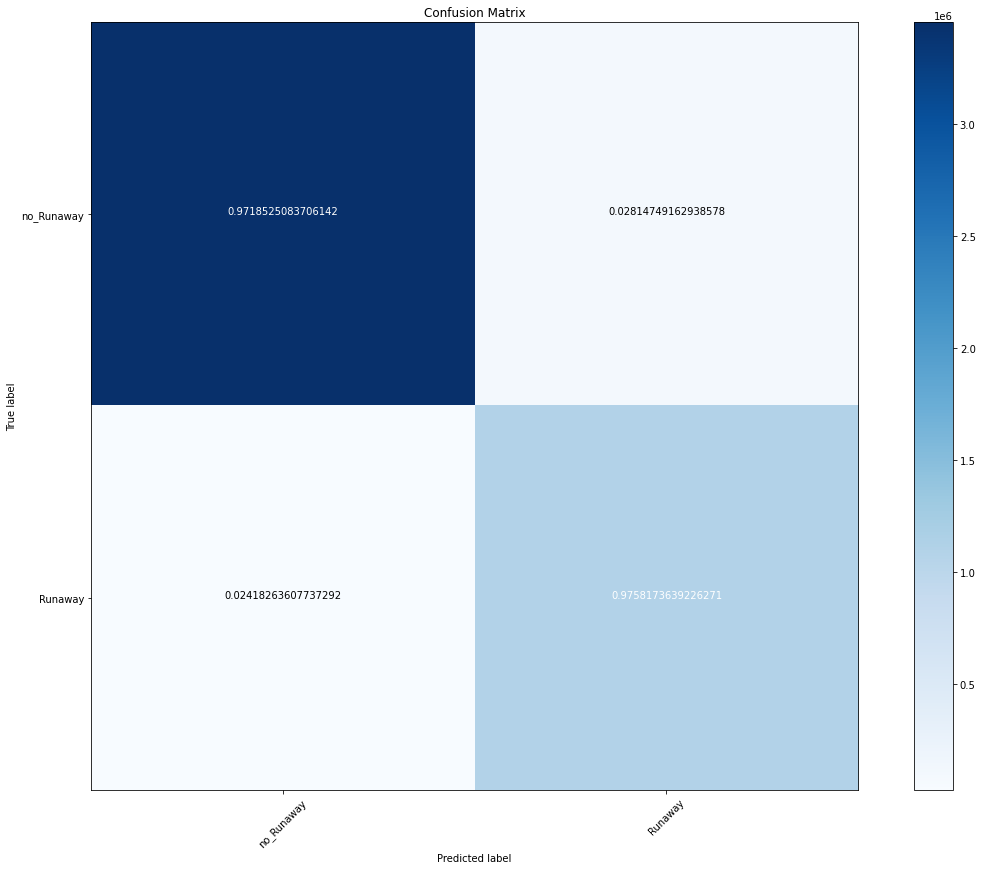

In [22]:
cm = confusion_matrix(y_true=X_reduced.iloc[:,-1], y_pred=clf2.predict(X_reduced.iloc[:,:-1]).round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# RandomForest

In [ ]:
clf3 = RandomForestClassifier(n_estimators=300, criterion='entropy',
                              max_depth=5, random_state=0).fit(Train_dataset_PCA, Train_dataset_PCA_Labels)

In [ ]:
clf3.score(Train_dataset_PCA_Reduced,Train_dataset_PCA_Labels_Reduced) # Train Acc

0.8605620385806144

In [ ]:
clf3.score(X_reduced.iloc[:,:-1],X_reduced.iloc[:,-1]) # Whole dataset Acc

0.9336040380658436

Normalized confusion matrix
[[0.99874708 0.00125292]
 [0.27469546 0.72530454]]


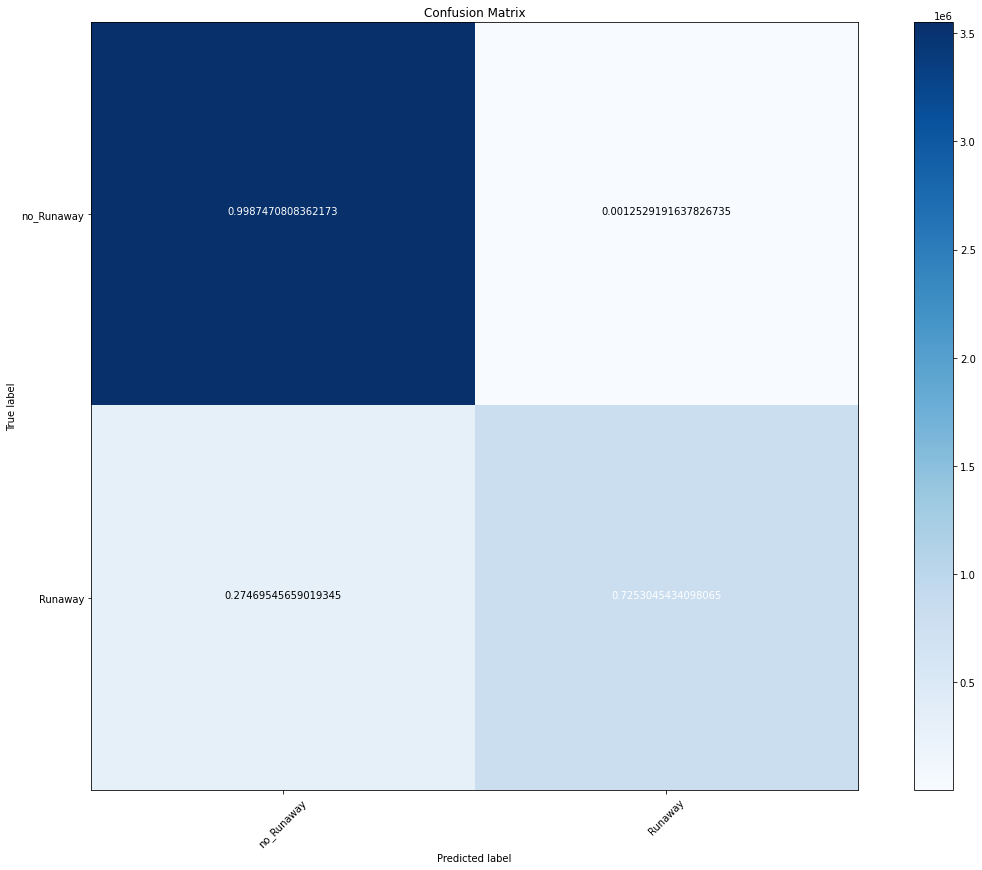

In [ ]:
cm = confusion_matrix(y_true=X_reduced.iloc[:,-1], y_pred=clf3.predict(X_reduced.iloc[:,:-1]).round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# XGBoost

## Primeiro treino PCA Reduzido

In [7]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",verbosity=2, max_depth=6, learning_rate=0.25,n_estimators=100)


In [8]:
xgb_model.fit(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced,
              eval_set=[(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced),(Test_dataset_PCA_reduced, Test_dataset_PCA_Labels_reduced)], # Train & Test evals
              eval_metric=['auc','error'],
              verbose=True)

[02:05:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.982152	validation_0-error:0.074923	validation_1-auc:0.981715	validation_1-error:0.073082
[02:05:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.987191	validation_0-error:0.062015	validation_1-auc:0.986041	validation_1-error:0.065152
[02:05:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.988997	validation_0-error:0.056752	validation_1-auc:0.987926	validation_1-error:0.06108
[02:05:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.989899	validation_0-error:0.052727	validation_1-auc:0.989099	validation_1-error:0.057222
[02:05:36] INFO: /workspace/src/tree

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.25, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=2)

Normalized confusion matrix
[[0.96924875 0.03075125]
 [0.01773729 0.98226271]]


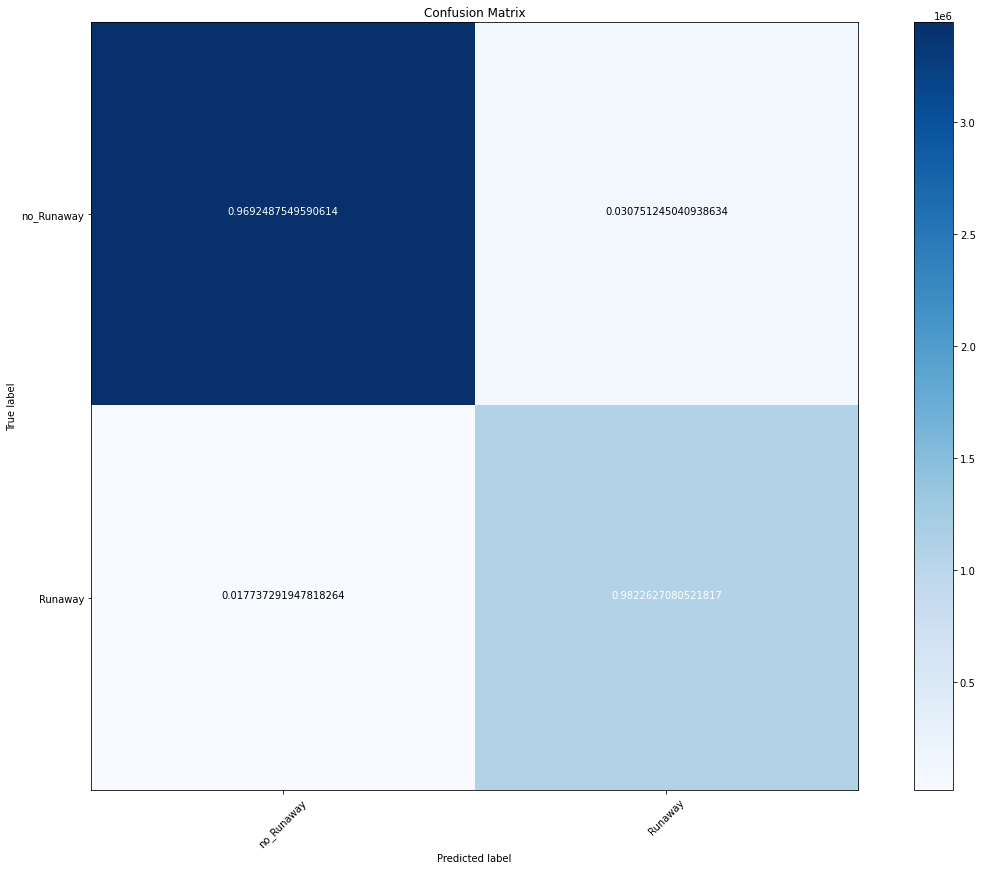

In [11]:
cm = confusion_matrix(y_true=X_reduced.iloc[:,-1], y_pred=xgb_model.predict(X_reduced.iloc[:,:-1]).round()) # Whole DataSet CM
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

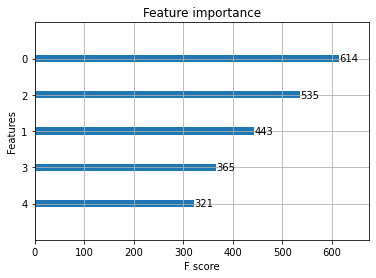

In [12]:
xgb.plot_importance(xgb_model)


In [13]:
xgb_model.score(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced)

0.9858299595141701

In [14]:
xgb_model.score(Test_dataset_PCA_reduced, Test_dataset_PCA_Labels_reduced)

0.9755679382768967

In [15]:
xgb_model.score(X_reduced.iloc[:,:-1],X_reduced.iloc[:,-1]) # 97.2% acc on the whole dataset without any tuning

0.9723491083676269

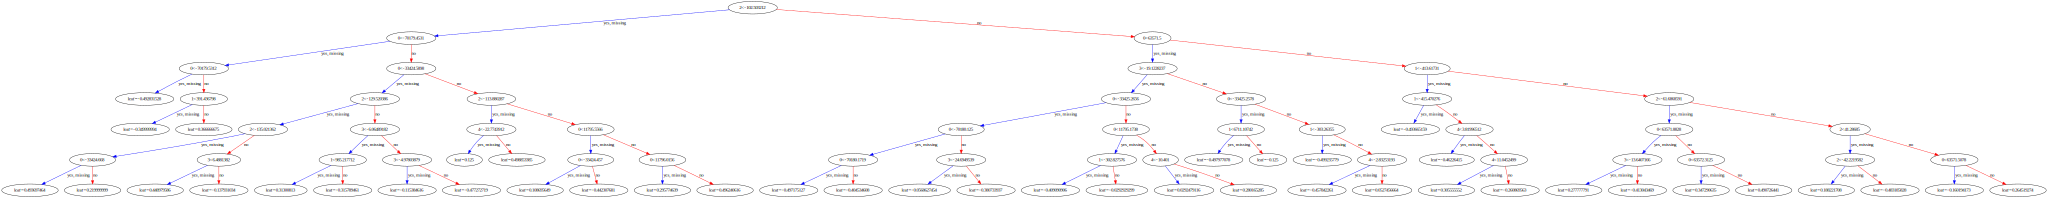

In [16]:
xgb.to_graphviz(xgb_model,num_trees=0)


##***Primeiro Treino PCA Completo

In [25]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",verbosity=2,max_depth=6,learning_rate=0.2,n_estimators=250)


In [26]:
xgb_model.fit(Train_dataset_PCA, Train_dataset_PCA_Labels,
              eval_set=[(Train_dataset_PCA, Train_dataset_PCA_Labels),(Test_dataset_PCA, Test_dataset_PCA_Labels)], # Train & Test evals
              eval_metric=['auc','error'],
              verbose=True)

[02:16:42] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[02:16:52] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.980883	validation_0-error:0.056912	validation_1-auc:0.980475	validation_1-error:0.085112
[02:17:00] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.98277	validation_0-error:0.055305	validation_1-auc:0.98256	validation_1-error:0.082283
[02:17:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.986621	validation_0-error:0.050438	validation_1-auc:0.986265	validation_1-error:0.087213
[02:17:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pr

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=2)

Normalized confusion matrix
[[0.99644204 0.00355796]
 [0.02473422 0.97526578]]


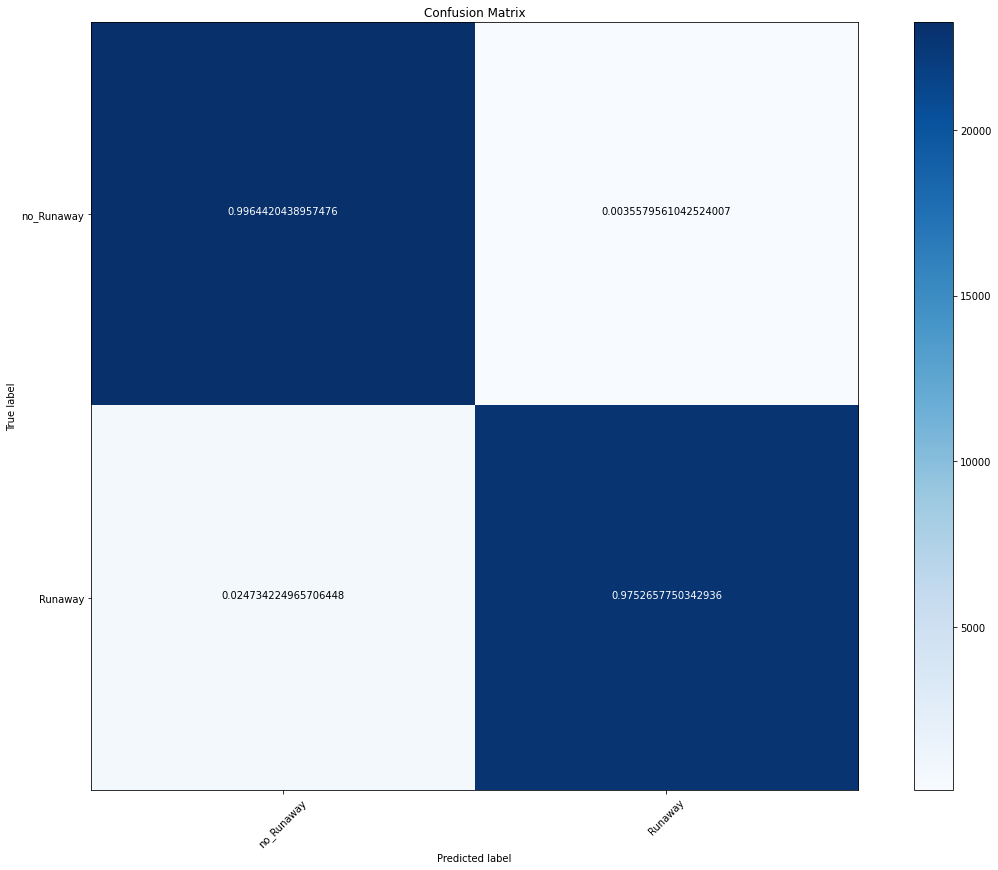

In [27]:
cm = confusion_matrix(y_true=Test_dataset_PCA_Labels, y_pred=xgb_model.predict(Test_dataset_PCA).round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

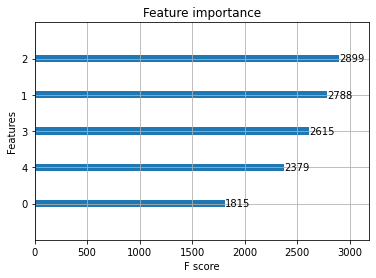

In [28]:
xgb.plot_importance(xgb_model)


In [29]:
xgb_model.score(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced)

0.9857585139318885

In [30]:
xgb_model.score(Test_dataset_PCA_reduced, Test_dataset_PCA_Labels_reduced)

0.9867123874839263

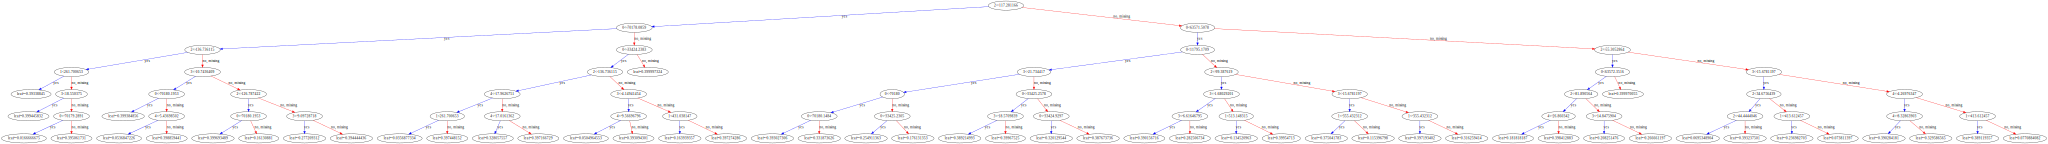

In [31]:
xgb.to_graphviz(xgb_model,num_trees=0)


##Primeiro treino Normal Reduzido

In [32]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",verbosity=2, max_depth=3, learning_rate=0.1,n_estimators=100)


In [33]:
xgb_model.fit(Train_dataset_Reduced, Train_dataset_Labels_Reduced,
              eval_set=[(Train_dataset_Reduced, Train_dataset_Labels_Reduced),(Test_dataset_reduced, Test_dataset_Labels_reduced)], # Train & Test evals
              eval_metric=['auc','error'],
              verbose=True)

[02:58:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation_0-auc:0.962944	validation_0-error:0.094784	validation_1-auc:0.962187	validation_1-error:0.100514
[02:58:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation_0-auc:0.981785	validation_0-error:0.079019	validation_1-auc:0.980383	validation_1-error:0.083798
[02:58:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	validation_0-auc:0.987133	validation_0-error:0.061181	validation_1-auc:0.985981	validation_1-error:0.065795
[02:58:45] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	validation_0-auc:0.98578	validation_0-error:0.062086	validation_1-auc:0.984138	validation_1-error:0.067938
[02:58:45] INFO: /workspace/src/tree/

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=2)

In [34]:
xgb_model.predict(Train_dataset_Reduced).round()

array([0, 0, 1, ..., 0, 0, 1])

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


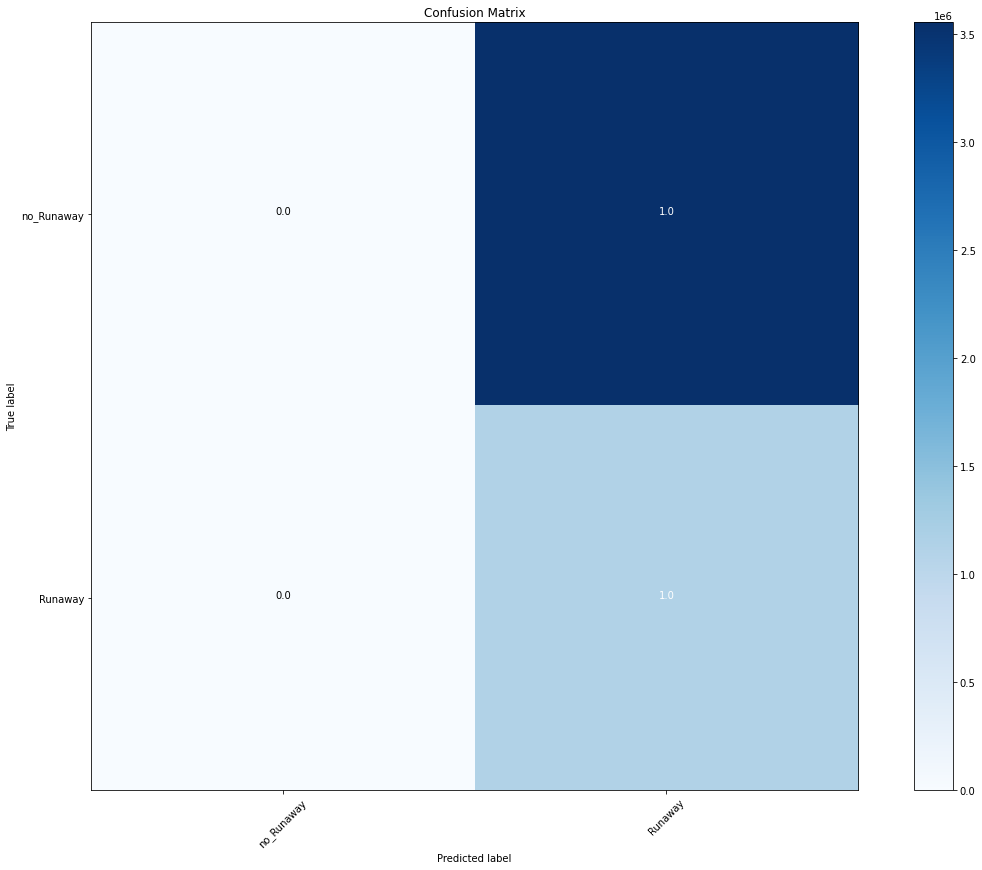

In [35]:
cm = confusion_matrix(y_true=dados_crus.iloc[:,-1], y_pred=xgb_model.predict(dados_crus.iloc[:,:-1].values).round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

**Por incrível que pareça, treinar o XGBoost no dataset comum reduzido faz as respostas saírem só 1 , testei várias vezes.
Por erro de ponto flutuante o python diz que não há predições diferentes de 1, quando na verdade a árvore memorizou as instâncias de operação normal dadas. 
Nota de repúdio à como o python trata números pequenos rsrs**


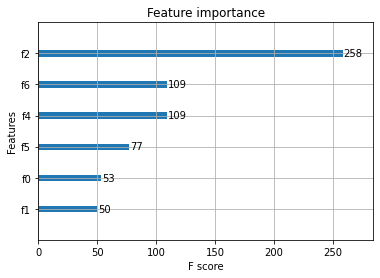

In [ ]:
xgb.plot_importance(xgb_model)


In [ ]:
xgb_model.score(Train_dataset_Reduced, Train_dataset_Labels_Reduced)

0.9639437961419386

In [ ]:
xgb_model.score(Test_dataset_reduced, Test_dataset_Labels_reduced)

0.9614230604372053

In [ ]:
xgb_model.score(dados_crus.iloc[:,:-1].values,dados_crus.iloc[:,-1]) 

0.23823302469135801

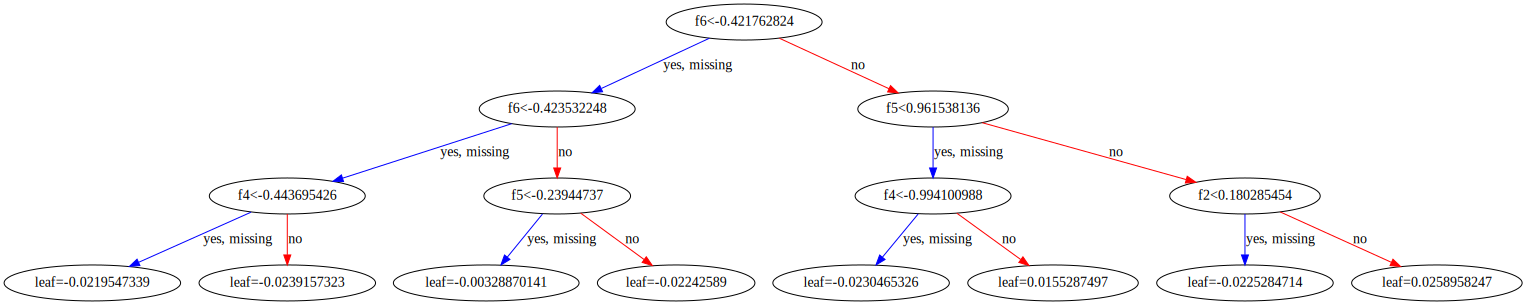

In [ ]:
xgb.to_graphviz(xgb_model,num_trees=99)


##Primeiro treino Normal Completo

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",verbosity=2,colsample_bytree=1, gamma=0.2, learning_rate=0.48, max_depth=6, n_estimators=100)


In [ ]:
xgb_model.fit(Train_dataset, Train_dataset_Labels,
              eval_set=[(Train_dataset, Train_dataset_Labels),(Test_dataset, Test_dataset_Labels)], # Train & Test evals
              eval_metric=['auc','error'],
              verbose=True)

[04:26:57] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[04:27:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.99546	validation_0-error:0.027329	validation_1-auc:0.875263	validation_1-error:0.270319
[04:27:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.997629	validation_0-error:0.019933	validation_1-auc:0.854691	validation_1-error:0.258981
[04:27:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.998068	validation_0-error:0.016138	validation_1-auc:0.882646	validation_1-error:0.269247
[04:27:36] INFO: /workspace/src/tree/updater_prune.cc:74: tree p

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.48, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=2)

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


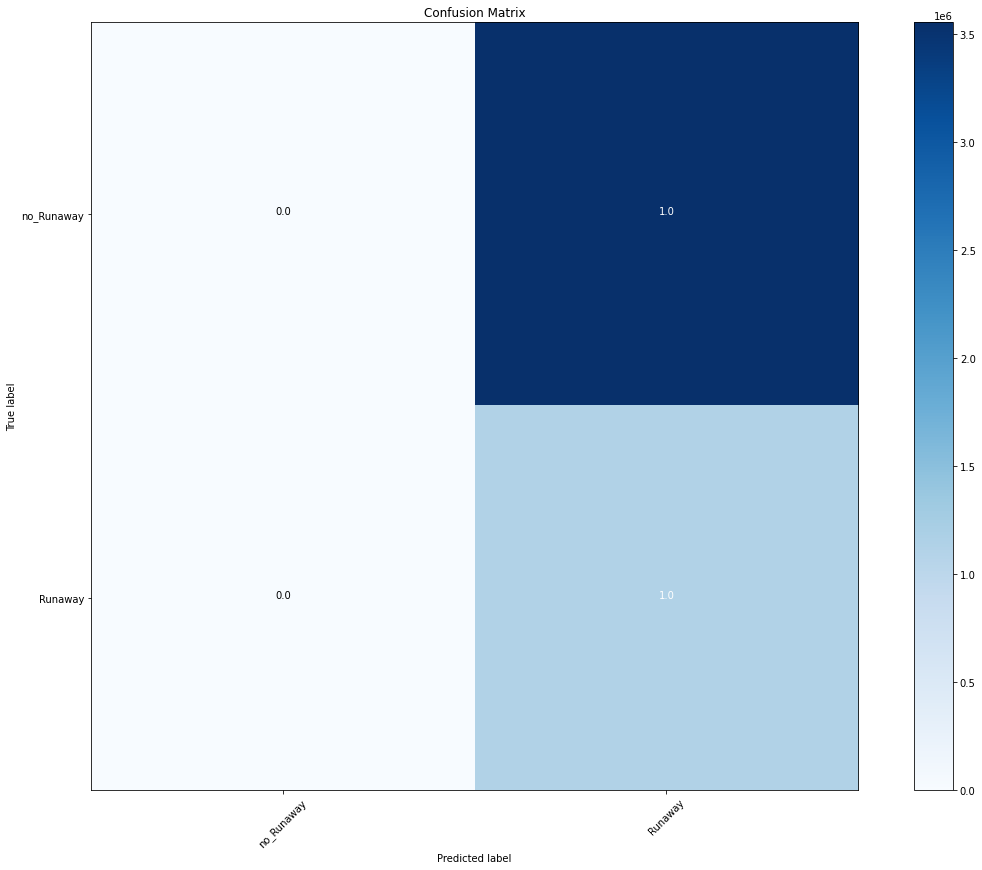

In [ ]:
cm = confusion_matrix(y_true=dados_crus.iloc[:,-1], y_pred=xgb_model.predict(dados_crus.iloc[:,:-1].values).round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

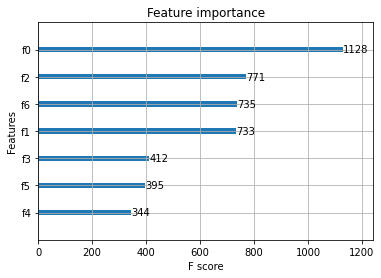

In [ ]:
xgb.plot_importance(xgb_model)


In [ ]:
xgb_model.score(Train_dataset_Reduced, Train_dataset_Labels_Reduced)

0.7412717313646107

In [ ]:
xgb_model.score(Test_dataset_reduced, Test_dataset_Labels_reduced)

0.7434633519074153

In [ ]:
xgb_model.score(dados_crus.iloc[:,:-1].values,dados_crus.iloc[:,-1]) # 85.9% acc on the whole dataset

0.23823302469135801

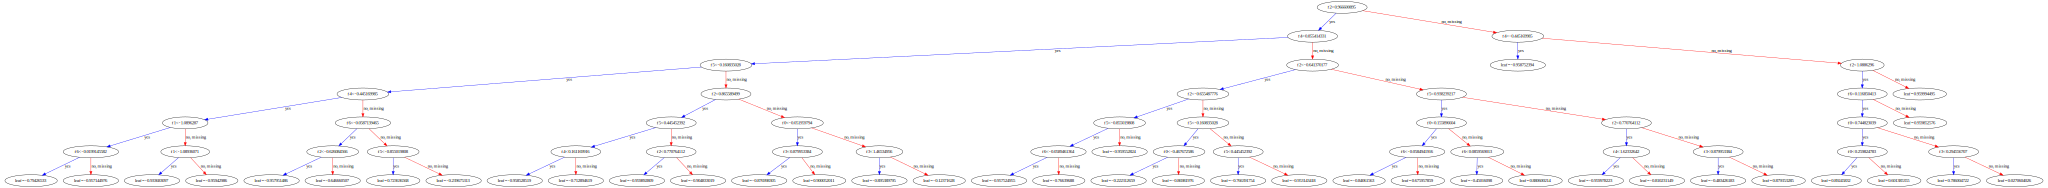

In [ ]:
xgb.to_graphviz(xgb_model,num_trees=0)


## Fine tunning

## 1° "Round" PCA Reduzido

In [36]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",verbosity=2)


In [37]:
params = {
    "colsample_bytree": [0.5,1,0.7],
    "gamma": [0.2,0.3,0.4],
    "learning_rate": [0.36,0.48], # default 0.1 
    "max_depth": [4,5,6], # default 3
    "n_estimators": [180,200,250], # default 100
}

In [38]:
search = GridSearchCV(xgb_model, param_grid=params,scoring=['f1','recall','accuracy'],n_jobs = -1,cv=5, verbose=3, return_train_score=True,refit='accuracy')

search.fit(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 49.6min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 50.6min finished


[03:51:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[03:51:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 4 pruned nodes, max_depth=6
[03:51:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[03:51:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[03:51:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 4 pruned nodes, max_depth=6
[03:51:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=6
[03:51:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 2 pruned nodes, max_depth=6
[03:51:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra no

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=2),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 1, 0.7],
                         'gamma': [0.2, 0.3, 0.4],
                         'learning_rate': [0.36, 0.48], 'max_depth':

In [39]:
search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2,
              learning_rate=0.48, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=2)

In [40]:
search.best_score_

0.9797094546320553

In [41]:
search.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.2,
 'learning_rate': 0.48,
 'max_depth': 6,
 'n_estimators': 200}

In [42]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",verbosity=2,colsample_bytree=0.7, gamma=0.2, learning_rate=0.48, max_depth=6, n_estimators=200)

In [43]:
xgb_model.fit(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced,
              eval_set=[(Train_dataset_PCA_Reduced, Train_dataset_PCA_Labels_Reduced),(Test_dataset_PCA_reduced, Test_dataset_PCA_Labels_reduced)], # Train & Test evals
              eval_metric=['auc','error'],
              verbose=True)

[03:52:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.955393	validation_0-error:0.105025	validation_1-auc:0.951806	validation_1-error:0.106087
[03:52:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 4 pruned nodes, max_depth=6
[1]	validation_0-auc:0.981955	validation_0-error:0.074589	validation_1-auc:0.979991	validation_1-error:0.077797
[03:52:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.987124	validation_0-error:0.058157	validation_1-auc:0.985704	validation_1-error:0.061294
[03:52:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.989554	validation_0-error:0.059681	validation_1-auc:0.988146	validation_1-error:0.060652
[03:52:31] INFO: /workspace/src/tree

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2,
              learning_rate=0.48, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=2)

In [44]:
xgb_model.score(Train_dataset_PCA_Reduced,Train_dataset_PCA_Labels_Reduced)

0.9995236961181234

In [45]:
xgb_model.score(Test_dataset_PCA_reduced, Test_dataset_PCA_Labels_reduced)

0.9813544792113159

Normalized confusion matrix
[[0.97840691 0.02159309]
 [0.01478183 0.98521817]]


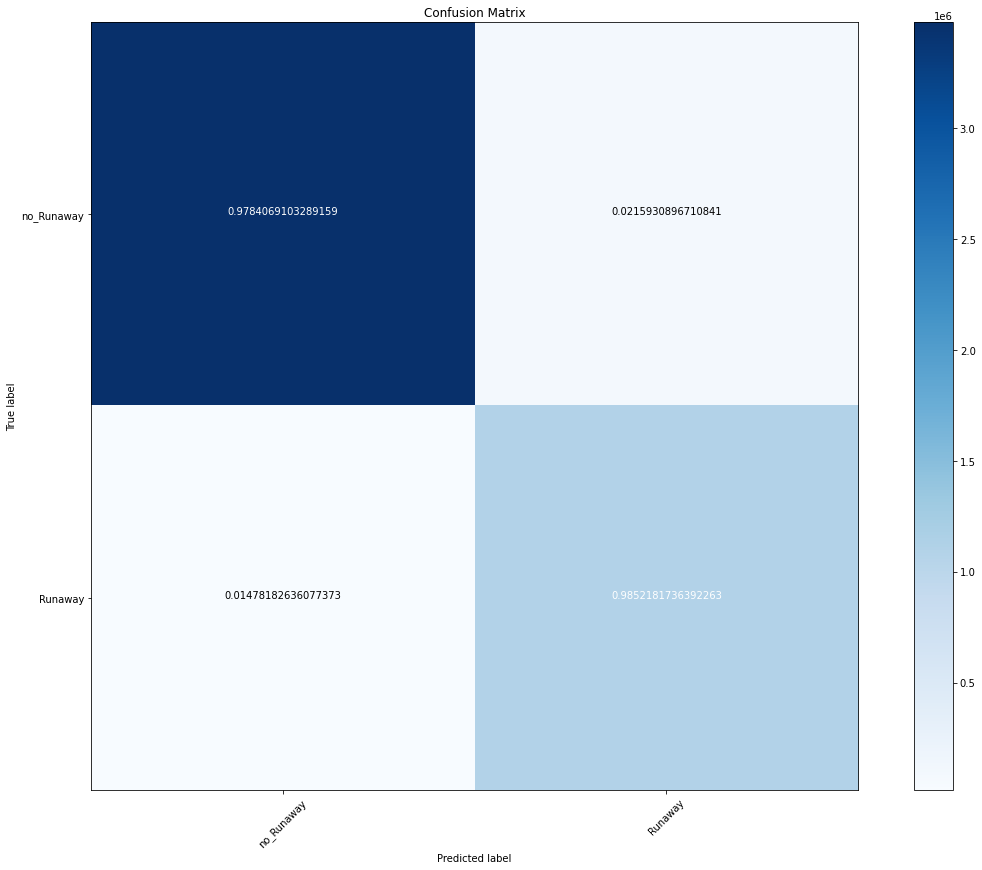

In [47]:
cm = confusion_matrix(y_true=X_reduced.iloc[:,-1], y_pred=xgb_model.predict(X_reduced.iloc[:,:-1]).round())
cm_plot_labels = ['no_Runaway','Runaway']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

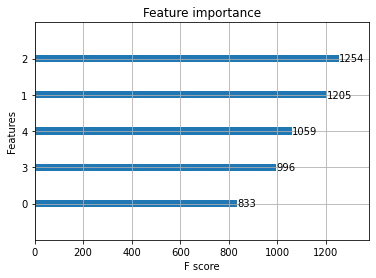

In [48]:
xgb.plot_importance(xgb_model, ax=None
                    , height=0.2, xlim=None, ylim=None, title='Feature importance'
                    , xlabel='F score', ylabel='Features', importance_type='weight', max_num_features=None, grid=True, show_values=True)


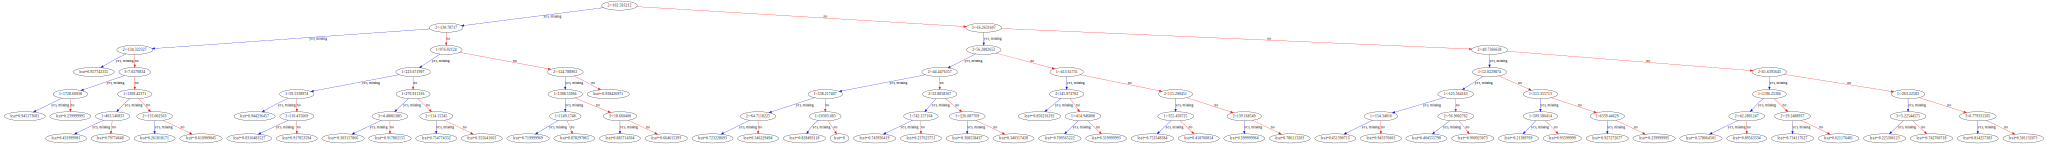

In [49]:
xgb.to_graphviz(xgb_model,num_trees=0)

In [51]:
xgb_model.score(X_reduced.iloc[:,:-1],X_reduced.iloc[:,-1])

0.9800295781893004

In [52]:
xgb_model.save_model('XGBoost')

In [ ]:
xgb_model.load_model('/content/drive/MyDrive/PF_Joao_Tupinamba/Teste GPU/XGBoost')